https://www.kaggle.com/laowingkin/netflix-movie-recommendation

# DLao의 마지막 편집-2020/09 전체 데이터로 업데이트 됨

Netflix Analytics-상관 관계 / CF를 통한 영화 추천

나는 Netflix를 좋아합니다! 모두가 그러 하듯?

이 프로젝트는 Netflix 내에서 영화 추천 메커니즘을 구축하는 것을 목표로합니다. 여기서 사용한 데이터 세트는 Netflix에서 직접 가져온 것입니다. 4 개의 텍스트 데이터 파일로 구성되며, 각 파일에는 2 천만 개 이상의 행이 포함됩니다. 17K 이상의 영화와 500,000 명 이상의 고객이 함께!

주요 과제 중 하나는 분석을 위해 이러한 모든 데이터를 커널에로드하는 것입니다. 저는 커널이 메모리 부족을 여러 번 겪었고이를보다 효율적으로 수행하는 방법을 여러 가지 시도했습니다. 제안을 환영합니다 !!!

이 커널은 지속적으로 업데이트됩니다! 제안을 환영합니다! 시작하자!


이 노트북이 어떤면에서 도움이된다면 자유롭게 포크와 찬성 투표를하세요!

**내용의 테이블:**
- 객관적인

- 데이터 조작

- 데이터 로딩
- 데이터보기
- 데이터 정리
- 데이터 슬라이싱
- 데이터 매핑
- 추천 모델

**aObjective**

데이터에서 배우고 자신과 타인의 행동을 기반으로 최고의 TV 프로그램을 사용자에게 추천합니다.

**데이터 조작**
**데이터 로딩**<br>
각 데이터 파일 (4 개가 있음)에는 아래 열이 있습니다.

- 영화 ID (각 새 영화 기록 / 파일의 첫 번째 줄)
- 고객 ID
- 등급 (1 ~ 5)
- 등급을 부여한 날짜
이름, 출시 연도 등과 같은 영화 배경에 대한 영화 ID 매핑이 포함 된 다른 파일이 있습니다.

시작하기 전에 필요한 라이브러리를 가져 오겠습니다.

In [3]:
import pandas as pd
import numpy as np
import math
import re
# from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# math 모듈 함수
#fabs, ceil, floor, exp, log, sqrt, sin, asin, cos, acos, tan, degrees, radians
# math 모듈 상수
#pi, e

In [4]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus= False)
plt.style.use('ggplot')
pd.options.display.max_columns = 100

In [5]:
# from scipy.sparse import csr_matrix

In [6]:
df= pd.read_csv('ratings.csv')

In [7]:
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [8]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [29]:
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [30]:
ax

C:\Anaconda3_64\lib\site-packages\pandas\plotting\_matplotlib\core.py:1445: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  return ax.barh(x, y, w, left=start, log=log, **kwds)


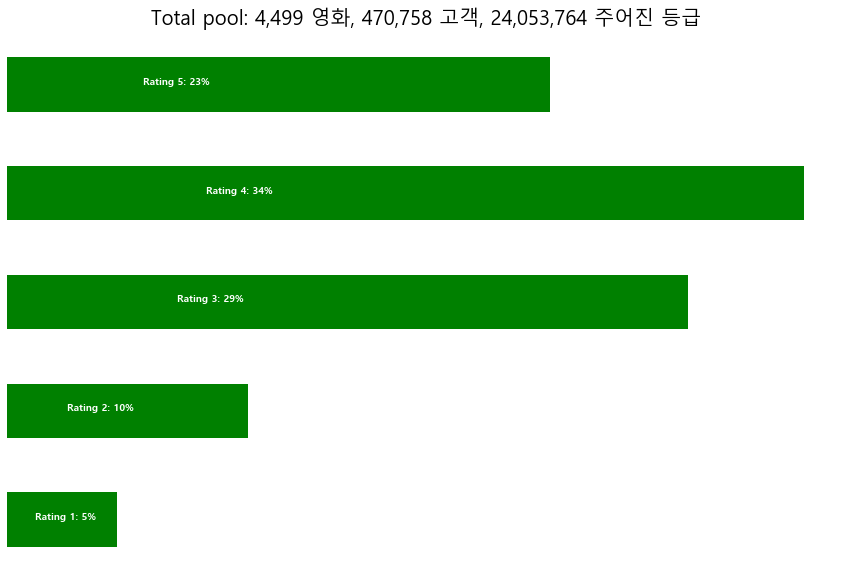

In [9]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# 영화 수 가져 오기
movie_count = df.isnull().sum()[1]

# 고객 수 얻기
cust_count = df['Cust_Id'].nunique() - movie_count

# 평가 횟수 가져 오기
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10), color = 'G')
plt.title('Total pool: {:,} 영화, {:,} 고객, {:,} 주어진 등급'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')
    

평점이 상대적으로 긍정적 인 경향이 있음을 알 수 있습니다 (> 3). 이는 불만족스러운 고객이 평가를 위해 노력하는 대신 그냥 떠나는 경향이 있기 때문일 수 있습니다. 우리는 이것을 명심할 수 있습니다. 낮은 등급의 영화는 일반적으로 정말 나쁘다는 것을 의미합니다.

# 데이터 정리
영화 ID는 정말 엉망인 가져 오기입니다! 동영상 ID 열을 추가하기 위해 데이터 프레임을 반복하면 커널이 너무 비효율적이기 때문에 메모리가 부족해집니다. 먼저 올바른 길이로 numpy 배열을 만든 다음 전체 배열을 기본 데이터 프레임에 열로 추가하여 내 작업을 수행합니다! 아래에서 어떻게하는지 보자

In [10]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy 접근 방식
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# 마지막 레코드와 해당 길이에 대한 설명
# numpy 접근 방식
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [11]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [12]:
last_record

array([[4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499, 4499,
        4499, 4499, 4499, 4499, 4499, 

In [13]:
movie_np

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 4.499e+03, 4.499e+03,
       4.499e+03])

In [14]:
# 영화 ID 행 제거
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

C:\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


In [15]:
df

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


# 데이터 슬라이싱
이제 데이터 세트가 엄청나게 커졌습니다. 여러 가지 방법을 시도했지만 메모리 오류없이 의도 한대로 커널을 실행할 수 없습니다. 따라서 아래의 데이터 품질을 개선하여 데이터 볼륨을 줄이려고했습니다.

- 리뷰가 너무 적은 영화 삭제 (상대적으로 인기가 없음)
- 리뷰를 너무 적게 제공하는 고객 제거 (비교적 활동이 적음) <br>

위의 벤치 마크를 사용하면 인기없는 영화와 비활성 고객이 매트릭스 관점에서 여전히 인기있는 영화 및 활성 고객과 동일한 볼륨을 차지하므로 효율성이 크게 향상됩니다 (NaN은 여전히 ​​공간을 차지함). 이것은 통계적 의미도 향상시키는 데 도움이 될 것입니다.

구현 방법을 살펴 보겠습니다.

데이터 세트를 피벗하여 거대한 행렬에 넣어 보겠습니다. 권장 시스템에 필요합니다.

In [16]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)

(470758, 4499)


In [22]:
df_p.isnull().sum()

Movie_Id
1       470211
2       470613
3       468746
4       470616
5       469618
         ...  
4495    470144
4496    461239
4497    470044
4498    470489
4499    470330
Length: 4499, dtype: int64

**데이터 매핑**

이제 영화 매핑 파일을로드합니다.

In [18]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


**추천 모델**

필요한 모든 데이터가로드되고 정리됩니다! 다음으로 추천 시스템에 대해 알아 보겠습니다.

**협업 필터링 권장**

더 빠른 프로세스를 위해 처음 10 만 행으로 협업 필터링의 성능을 평가합니다.

In [23]:
reader = Reader()

NameError: name 'Reader' is not defined

In [ ]:
# 빠른 실행 시간을 위해 상위 10 만 행만 가져옵니다.
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

다음은 사용자 783514가 과거에 좋아했던 것입니다.

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

사용자 785314가보고 싶어 할 영화를 예측해 보겠습니다.

In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

**Pearsons의 R 상관 관계로 권장**

작동 방식은 Pearsons의 R 상관 관계를 사용하여 모든 영화 쌍의 리뷰 점수 간의 선형 상관 관계를 측정 한 다음 상관 관계가 가장 높은 상위 10 개 영화를 제공하는 것입니다.

In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

당신이 'What the # $ *! 우리는 알고 있습니까!? '

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

X2: X-Men United:

In [ ]:
recommend("X2: X-Men United", 0)

좋은 읽기 바랍니다. 이 커널 (더 많은 모델 등)을 계속 업데이트하겠습니다. 제안을 환영합니다!